In [1]:
import zipfile
import numpy as np
import pandas as pd

import statsmodels.formula.api as sm

In [2]:
# with zipfile.ZipFile("data/covid.zip","r") as zip:
#     zip.extractall("data")

In [4]:
cases = pd.read_csv('data/time_series_covid19_confirmed_global.csv')
dead = pd.read_csv('data/time_series_covid19_deaths_global.csv')
recov = pd.read_csv('data/time_series_covid19_recovered_global.csv')

In [47]:
col = 'Country/Region'

raw = pd.concat([
    cases.assign(type = 'cases'),
    dead.assign(type = 'dead'),
    recov.assign(type = 'recov'),
])

In [48]:
raw.loc[raw[col] == 'Germany']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,type
130,NaN,Germany,51.165691,10.451526,0,0,0,0,0,1,...,283712,285026,286339,288631,290471,292913,295539,298374,300027,cases
130,NaN,Germany,51.165691,10.451526,0,0,0,0,0,0,...,9451,9459,9464,9468,9483,9495,9509,9518,9531,dead
117,NaN,Germany,51.165691,10.451526,0,0,0,0,0,0,...,249164,250104,250866,252693,255212,256861,258220,259722,260916,recov


In [49]:
sir = (
    raw
    .loc[raw[col] == 'Germany']
    .drop(['Province/State','Lat','Long'], axis = 1)
    .melt([col, 'type'], var_name = 'date', value_name = 'number')
    .pivot_table('number', 'date', 'type')
    .reset_index()
)

In [50]:
sir = sir.assign(
    date = sir.date.astype('datetime64[ns]'),
    infec = sir.cases - sir.dead - sir.recov
).query('infec > 0')
sir = sir.sort_values('date').reset_index().drop('index',axis = 1)
sir = sir.assign(
    time = range(sir.shape[0]),
    loginf = np.log(sir.infec)
    )

In [51]:
sir.describe()

type,cases,dead,recov,infec,time,loginf
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,150747.143426,5992.597610,127664.219124,17090.326693,125.000000,8.479978
std,93018.234586,3939.610527,88145.236260,17393.021488,72.601653,2.742634
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,64490.000000,589.000000,11355.500000,6415.500000,62.500000,8.766468
50%,183410.000000,8540.000000,165352.000000,11092.000000,125.000000,9.313979
75%,211112.500000,9154.000000,192772.000000,21306.500000,187.500000,9.966762
max,300027.000000,9531.000000,260916.000000,72864.000000,250.000000,11.196350


<AxesSubplot:xlabel='date'>

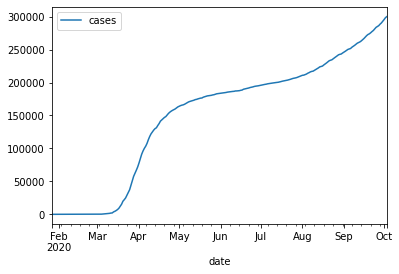

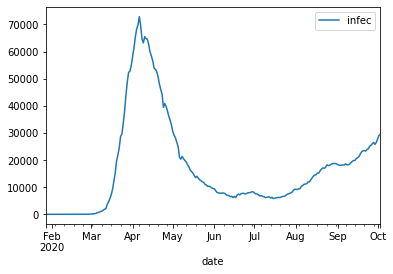

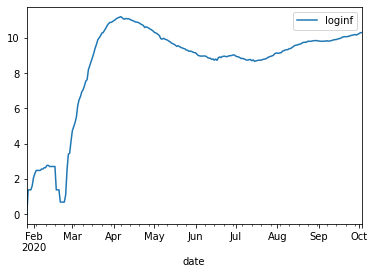

In [52]:
sir.plot('date', 'cases')
sir.plot('date', 'infec')
sir.plot('date', 'loginf')

<AxesSubplot:>

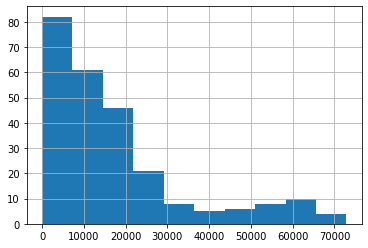

In [53]:
sir.infec.hist()

<AxesSubplot:>

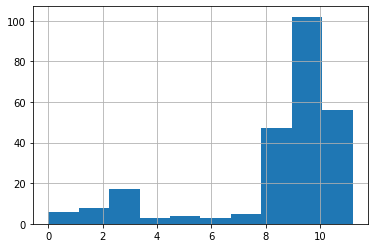

In [54]:
sir.loginf.hist()

In [55]:
ols = sm.ols('loginf ~ time', data = sir).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 loginf   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     126.5
Date:                Thu, 22 Oct 2020   Prob (F-statistic):           5.32e-24
Time:                        12:27:40   Log-Likelihood:                -557.34
No. Observations:                 251   AIC:                             1119.
Df Residuals:                     249   BIC:                             1126.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.7393      0.282     20.376      0.000       5.185       6.294
time           0.0219      0.002     11.247      0.000       0.018       0.026
==============================================================================
Omnibus:                        2.346   Durbin-Watson:                   0.008
Prob(Omnibus):                  0.309   Jarque-Bera (JB):                2.260
Skew:                          -0.232   Prob(JB):                        0.323
Kurtosis:                       2.978   Cond. No.                         288.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
sir = sir.assign(fit = ols.fittedvalues)

1.0221674916088526

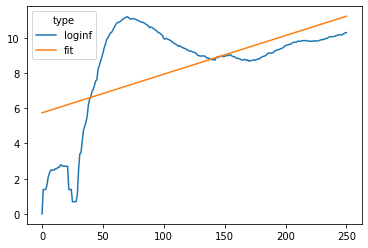

In [58]:
sir[['loginf','fit']].plot()
np.exp(ols.params['time'])

In [59]:
import ipywidgets as widgets
from ipywidgets import FloatSlider
import matplotlib.pyplot as plt

def fs(val, min, max, step):
    return FloatSlider(value=val, min=min, max=max, step=step, continuous_update = False)

In [82]:
# define the update function
def update(datemin, datemax):
    global sir
    data = sir
    if datemin >= datemax:
        plt.plot()
        plt.title('Wrong time selection')
        return()
    
    data = data.loc[data.time.between(datemin, datemax, inclusive = True)]
    fit = sm.ols('loginf ~ time', data = data).fit()
    data.plot('time', 'loginf', label = 'actual')
    plt.xticks(rotation = 40)
    plt.scatter(data.time, fit.fittedvalues, s = 0.5, color = 'red', label = 'fitted')
    plt.legend()
    plt.title('R0 = ' + str(np.exp(fit.params.loc['time'])))

In [72]:
widgets.interact(update,
                 datemin = fs(0, 0, sir.shape[0]-10, 1),
                 datemax = fs(sir.shape[0], 10, sir.shape[0], 1)
                 )

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='datemin', max=241.0, step=1…

<function __main__.update(datemin, datemax)>